In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 1.2 MB/s 
     |████████████████████████████████| 13.1 MB 38.5 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=dadab3e8a50c1b66318b328b2f422fc27198833ee42805ad2ba65cf372e3713a
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
from calendar import month_name
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, auc
from pdpbox import pdp, info_plots

In [ ]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'{name}_{part}.png')
        plt.show()

### loading data 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
hotel3 = pd.read_csv('drive/MyDrive/hotel3.csv', index_col=0)

In [27]:
# split data
X, y = hotel3.iloc[:,1:], hotel3.iloc[:,0]
total_data = len(X.index)
split = round(total_data*0.8)
X_train = X.iloc[:split, :]
X_test = X.iloc[split:, :]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [28]:
# Imputation (feature = agent)
#https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/
imputer = KNNImputer()
imputer.fit(X_train)
X_trans = imputer.transform(X_train)

In [29]:
# Data Normalization
# https://machinelearningmastery.com/data-preparation-without-data-leakage/
scaler = MinMaxScaler()
scaler.fit(X_trans)
X_train = scaler.transform(X_trans)


In [16]:
print('missing: %d' % sum(np.isnan(X_trains).flatten()))

missing: 0


In [31]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns.tolist())

### Tuning

In [ ]:
# Hyperparameters
# lr = [0.0001, 0.001, 0.1, 0.3]
'''
lr = [0.001, 0.1, 0.3]
depth = [i for i in np.arange(5, 21, 5)]
child_weight = [i for i in range(0, 5)]
sample_ratio = [i/10 for i in range(3, 8)]
tree_ratio = [i/10 for i in range(3, 8)]
'''
lr = [0.001, 0.1]
depth = [i for i in np.arange(15, 21, 5)]
child_weight = [i for i in range(0, 2)]
sample_ratio = [i/10 for i in range(4, 8)]
tree_ratio = [i/10 for i in range(4, 8)]

In [ ]:
results = []
for l in lr:
    for d in depth:
        for w in child_weight:
            for sample in sample_ratio:
                for trees in tree_ratio:
                    # hyperparameters
                    params = {'eta':l, 
                              'max_depth': d, 
                              'min_child_weight': w,
                              'subsample': sample,
                              'colsample_bytree': trees,
                              'scale_pos_weight': 2,
                              'tree_method': 'gpu_hist'}
                    print(params)
                    # cross validation
                    cv_hist = xgb.cv(params, 
                                    dtrain, 
                                    num_boost_round=1000, 
                                    nfold=10, 
                                    stratified=True, 
                                    metrics=['auc','error'], 
                                    early_stopping_rounds=5, 
                                    verbose_eval=5, 
                                    seed=42)
                    # average result 
                    train_error = cv_hist.iloc[-1,2]
                    train_auc = cv_hist.iloc[-1,0]
                    test_error = cv_hist.iloc[-1,-2]
                    test_auc = cv_hist.iloc[-1,4]
                    results.append([[l, d, w, sample, trees], [train_error,test_error, train_auc, test_auc]])

{'eta': 0.001, 'max_depth': 15, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.4, 'gamma': 1, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:0.917152+0.00323096	train-error:0.123828+0.00318933	test-auc:0.881656+0.0144997	test-error:0.168016+0.0145422
[10]	train-auc:0.993369+0.000395491	train-error:0.0487659+0.0019167	test-auc:0.980526+0.00368848	test-error:0.0795797+0.00859987
{'eta': 0.001, 'max_depth': 15, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.4, 'gamma': 3, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:0.917152+0.00323096	train-error:0.123828+0.00318933	test-auc:0.881656+0.0144997	test-error:0.168016+0.0145422
[10]	train-auc:0.993369+0.000395491	train-error:0.0487659+0.0019167	test-auc:0.980526+0.00368848	test-error:0.0795797+0.00859987
{'eta': 0.001, 'max_depth': 15, 'min_child_weight': 0, 'subsample': 0.4, 'colsample_bytree': 0.4, 'gamma': 5, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist'}
[0]	train-auc:

In [ ]:
result_np = np.array(results)
result = pd.DataFrame(result_np, columns=['parameters', 'validation results'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
result[['eta', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree']] = result['parameters'].apply(pd.Series)
result[['train_error', 'test_error', 'train_auc', 'test_auc']] = result['validation results'].apply(pd.Series)
result.drop(columns=['parameters', 'validation results'], inplace=True)

In [ ]:
best_params = result.sort_values(['test_error']).iloc[0,:5]
print(best_params.to_list())
best_result = result.sort_values(['test_error']).iloc[0,5:]
print(best_result.to_list())

[0.1, 15.0, 1.0, 0.5, 0.6]
[0.012850400000000001, 0.0494112, 0.9996074, 0.986209]


In [ ]:
# {'eta': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.6} reaches lowest test-error 
# gamma [0,1,3,5] has no effect on the model performance, therefore set as default

In [ ]:
# build final model
# best_params
params = {'eta':best_params[0], 
          'max_depth': int(best_params[1]), 
          'min_child_weight': best_params[2],
          'subsample': best_params[3],
          'colsample_bytree': best_params[4],
          'scale_pos_weight': 2,
          'tree_method': 'gpu_hist',
          'eval_metric': ['auc', 'error'],
          'seed':42}
print(params)

epochs = 100

bst = xgb.train(params, 
                dtrain, 
                epochs, 
                [(dtrain, 'train')],
                early_stopping_rounds=5, 
                verbose_eval=2)

{'eta': 0.1, 'max_depth': 15, 'min_child_weight': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'gamma': 5, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'eval_metric': ['auc', 'error'], 'seed': 42}
[0]	train-auc:0.973358	train-error:0.056515
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[2]	train-auc:0.990357	train-error:0.038478
[4]	train-auc:0.99358	train-error:0.030498
[6]	train-auc:0.996192	train-error:0.027656
[8]	train-auc:0.99732	train-error:0.024923
[10]	train-auc:0.997948	train-error:0.022737
[12]	train-auc:0.998252	train-error:0.021098
[14]	train-auc:0.998748	train-error:0.019458
[16]	train-auc:0.9989	train-error:0.01749
[18]	train-auc:0.999086	train-error:0.016725
[20]	train-auc:0.99922	train-error:0.015632
[22]	train-auc:0.999317	train-error:0.014648
[24]	train-auc:0.999365	train-error:0.01432
[26]	train-auc:0.99943	train-error:0.013992
[28]	train-auc:0.999486	train-er

### final model

In [36]:
# build final model
best_params = [0.1, 15.0, 1.0, 0.5, 0.6]
params = {'eta':best_params[0], 
          'max_depth': int(best_params[1]), 
          'min_child_weight': best_params[2],
          'subsample': best_params[3],
          'colsample_bytree': best_params[4],
          'scale_pos_weight': 2,
          'tree_method': 'gpu_hist',
          'eval_metric': ['auc', 'error'],
          'seed':42}
print(params)

epochs = 100

bst = xgb.train(params, 
                dtrain, 
                epochs, 
                [(dtrain, 'train')],
                early_stopping_rounds=5, 
                verbose_eval=2)

{'eta': 0.1, 'max_depth': 15, 'min_child_weight': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'eval_metric': ['auc', 'error'], 'seed': 42}
[0]	train-auc:0.886422	train-error:0.229781
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[2]	train-auc:0.94443	train-error:0.156245
[4]	train-auc:0.952044	train-error:0.145207
[6]	train-auc:0.956495	train-error:0.130902
[8]	train-auc:0.960311	train-error:0.127834
[10]	train-auc:0.963194	train-error:0.12131
[12]	train-auc:0.966605	train-error:0.11488
[14]	train-auc:0.968497	train-error:0.110901
[16]	train-auc:0.971535	train-error:0.102449
[18]	train-auc:0.973371	train-error:0.099067
[20]	train-auc:0.976332	train-error:0.09092
[22]	train-auc:0.977749	train-error:0.088616
[24]	train-auc:0.979222	train-error:0.085537
[26]	train-auc:0.980195	train-error:0.083076
[28]	train-auc:0.981621	train-error:0.07

In [33]:
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X.columns.tolist())

In [37]:
y_train_preds = np.round(bst.predict(dtrain, ntree_limit=bst.best_ntree_limit))
y_preds = np.round(bst.predict(dtest, ntree_limit=bst.best_ntree_limit))

In [38]:
print(classification_report(y_train,y_train_preds,target_names=['not_canceled', 'canceled']))
print(classification_report(y_test,y_preds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       0.99      0.97      0.98     59625
    canceled       0.95      0.99      0.97     35866

    accuracy                           0.98     95491
   macro avg       0.97      0.98      0.97     95491
weighted avg       0.98      0.98      0.98     95491

              precision    recall  f1-score   support

not_canceled       0.89      0.95      0.92     15525
    canceled       0.90      0.79      0.84      8348

    accuracy                           0.89     23873
   macro avg       0.89      0.87      0.88     23873
weighted avg       0.89      0.89      0.89     23873



In [ ]:
# original from model_tryout
print(classification_report(y_train,y_train_preds,target_names=['not_canceled', 'canceled']))
print(classification_report(y_test,y_preds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       1.00      0.99      0.99      2984
    canceled       0.99      1.00      1.00      6164

    accuracy                           1.00      9148
   macro avg       1.00      0.99      1.00      9148
weighted avg       1.00      1.00      1.00      9148

              precision    recall  f1-score   support

not_canceled       0.82      0.82      0.82       682
    canceled       0.92      0.92      0.92      1605

    accuracy                           0.89      2287
   macro avg       0.87      0.87      0.87      2287
weighted avg       0.89      0.89      0.89      2287



In [ ]:
roc_auc_score(y_test, y_preds)

0.8707731520815633

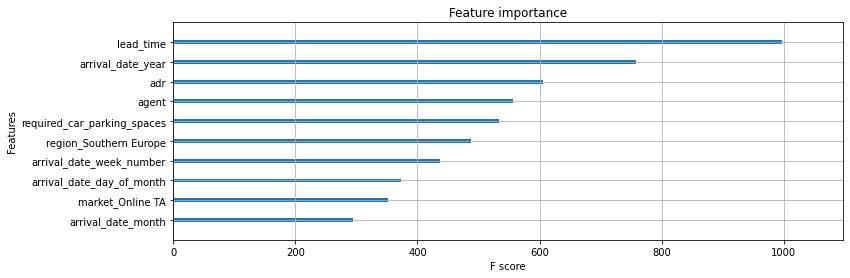

In [ ]:
xgb.plot_importance(bst, importance_type='total_gain', max_num_features=10, show_values=False)

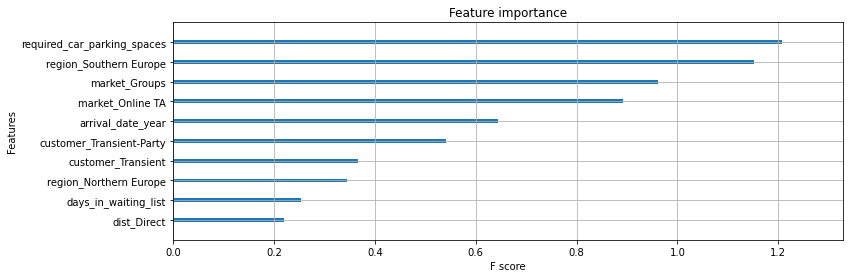

In [ ]:
xgb.plot_importance(bst, importance_type='gain', max_num_features=10, show_values=False)

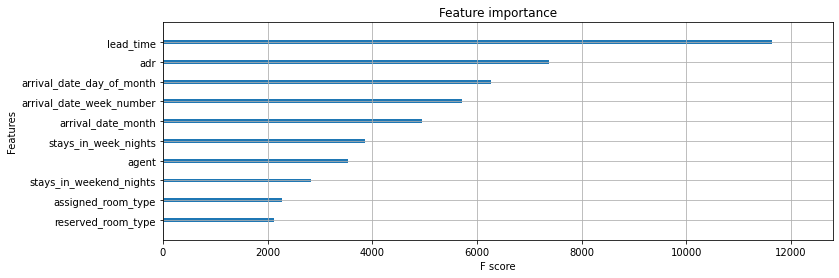

In [ ]:
xgb.plot_importance(bst, importance_type='weight', max_num_features=10, show_values=False)

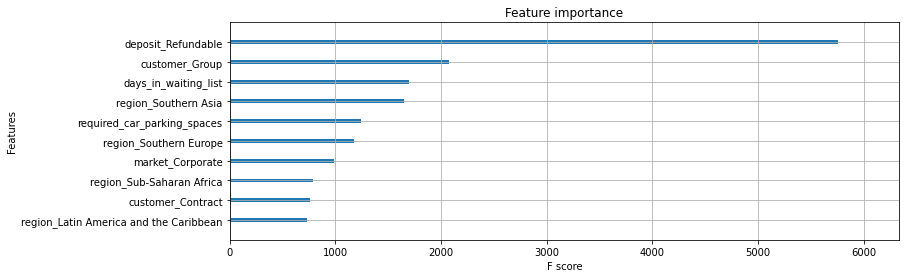

In [ ]:
xgb.plot_importance(bst, importance_type='cover', max_num_features=10, show_values=False)

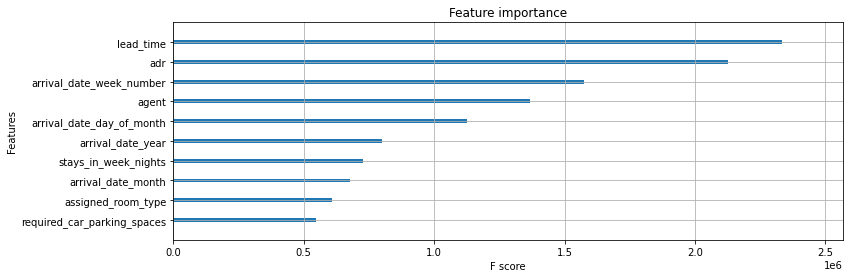

In [ ]:
xgb.plot_importance(bst, importance_type='total_cover', max_num_features=10, show_values=False)